# House Sale Prices Study

## Objectives

* Answer business requirement 1:
    * The client is interested in discovering how the house attributes correlate with the sale price. Therefore, the client expects data visualizations of the correlated variables against the sale price to show that

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv

## Outputs

* Calculate the correlation coefficients between the house attributes and the sale price and visualize in a heat map. Create scatterplots of each correlated attribute against the sell price.

* Save correlation coefficients to:
outputs/house_prices_study/v1/corr_df_rev.csv

* Save dictionary used in encoding object variables to:
outputs/house_prices_study/v1/dic.pkl

## Conclusions
* Seven variables out of 23 are strongly correlated with sale price
* The sale price distribution is skewed to the right

---

## Install python packages

In [1]:
%pip install -r /workspaces/Project-heritage-housing-issues/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/workspaces/Project-heritage-housing-issues/requirements.txt'

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Project-heritage-housing-issues'

# Load Data

In [5]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv"))
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0
3,961.0,NaN,NaN,No,216.0,ALQ,540.0,NaN,642.0,Unf,...,60.0,0.0,35.0,5,7,756.0,NaN,1915,1970,140000.0
4,1145.0,NaN,4.0,Av,655.0,GLQ,490.0,0.0,836.0,RFn,...,84.0,350.0,84.0,5,8,1145.0,NaN,2000,2000,250000.0
5,796.0,566.0,1.0,No,732.0,GLQ,64.0,NaN,480.0,Unf,...,85.0,0.0,30.0,5,5,796.0,NaN,1993,1995,143000.0
6,1694.0,0.0,3.0,Av,1369.0,GLQ,317.0,NaN,636.0,RFn,...,75.0,186.0,57.0,5,8,1686.0,NaN,2004,2005,307000.0
7,1107.0,983.0,3.0,Mn,859.0,ALQ,216.0,NaN,484.0,NaN,...,NaN,240.0,204.0,6,7,1107.0,NaN,1973,1973,200000.0
8,1022.0,752.0,2.0,No,0.0,Unf,952.0,NaN,468.0,Unf,...,51.0,0.0,0.0,5,7,952.0,NaN,1931,1950,129900.0
9,1077.0,0.0,2.0,No,851.0,GLQ,140.0,NaN,205.0,RFn,...,50.0,0.0,4.0,6,5,991.0,NaN,1939,1950,118000.0


# Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean in a business context

In [8]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.0.3/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.0.3/u/import-error

# Correlation Study
We use .corr() for spearman method, and sort the correlations in descending order. We start with numeric variables such as '1stFlrSF' (First Floor square feet). For each variable we remove missing data and zeros and calculate the correlation coefficient between the variable and the sale price. We store it in a list and convert the list to a Pandas Series.

In [9]:
lst = []
# Remove first zeros and missing values
for col in df.columns[df.dtypes!='object'].to_list():
    if col != 'SalePrice':
        df1 = df[df[col]!=0]
        df2 = df1[df1[col].notnull()]
        df3 = df2.filter(['SalePrice', col])
        corr_spearman = df3.corr(method='spearman')['SalePrice'][1:].round(2)
        lst.append(corr_spearman[col])
corr_num = pd.Series(index=df.columns[df.dtypes!='object'].drop(['SalePrice']).to_list(), data=lst).sort_values(key=abs, ascending=False)
print(corr_num)

OverallQual      0.81
GrLivArea        0.73
2ndFlrSF         0.69
YearBuilt        0.65
GarageArea       0.61
GarageYrBlt      0.59
1stFlrSF         0.58
TotalBsmtSF      0.58
YearRemodAdd     0.57
LotArea          0.46
LotFrontage      0.41
BsmtFinSF1       0.40
MasVnrArea       0.33
BedroomAbvGr     0.24
OpenPorchSF      0.16
WoodDeckSF       0.14
OverallCond     -0.13
BsmtUnfSF        0.11
EnclosedPorch   -0.01
dtype: float64


* To calculate the correlation coefficients of the four object variables, we first encode them to numeric variables manually.

**BsmtExposure:** Refers to walkout or garden level walls Gd: Good Exposure; Av: Average Exposure; Mn: Mimimum Exposure; No: No Exposure; None: No Basement

**BsmtFinType1:** Rating of basement finished area GLQ: Good Living Quarters; ALQ: Average Living Quarters; BLQ: Below Average Living Quarters; Rec: Average Rec Room; LwQ: Low Quality; Unf: Unfinshed; None: No Basement

**GarageFinish:** Interior finish of the garage Fin: Finished; RFn: Rough Finished; Unf: Unfinished; None: No Garage

**KitchenQual:** Kitchen quality Ex: Excellent; Gd: Good; TA: Typical/Average; Fa: Fair; Po: Poor

In [10]:
# The dictionary dic maps the ordinal categorical values to integers for the four object variables.
dic = {'BsmtExposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0}, 'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0}, 'GarageFinish': {'Fin': 2, 'RFn': 1, 'Unf': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}
lst = []
# Remove first None and missing values
for col in df.columns[df.dtypes=='object'].to_list():
    df1 = df[df[col]!='None']
    df2 = df1[df1[col].notnull()]
    df3[col] = df2[col].replace(dic[col])
    df4 = df3.filter(['SalePrice', col])
    corr_spearman = df4.corr(method='spearman')['SalePrice'][1:].round(2)
    lst.append(corr_spearman[col])
corr_object = pd.Series(index=df.columns[df.dtypes=='object'].to_list(), data=lst).sort_values(key=abs, ascending=False)
print(corr_object)

KitchenQual     0.67
GarageFinish    0.60
BsmtFinType1    0.33
BsmtExposure    0.30
dtype: float64


* **Combine both series of correlation coefficients and sort in ascending order for the heatnap:**

In [11]:
corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)
corr_df = pd.DataFrame(index=['SalePrice'], columns=corr.index, data=corr.values.reshape(1,-1).tolist())
corr_df_rev = corr_df[corr_df.columns[::-1]]
corr

/tmp/ipykernel_2730/448136342.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr = corr_num.append(corr_object).sort_values(key=abs, ascending=False).round(2)


OverallQual      0.81
GrLivArea        0.73
2ndFlrSF         0.69
KitchenQual      0.67
YearBuilt        0.65
GarageArea       0.61
GarageFinish     0.60
GarageYrBlt      0.59
1stFlrSF         0.58
TotalBsmtSF      0.58
YearRemodAdd     0.57
LotArea          0.46
LotFrontage      0.41
BsmtFinSF1       0.40
MasVnrArea       0.33
BsmtFinType1     0.33
BsmtExposure     0.30
BedroomAbvGr     0.24
OpenPorchSF      0.16
WoodDeckSF       0.14
OverallCond     -0.13
BsmtUnfSF        0.11
EnclosedPorch   -0.01
dtype: float64

## Heatmap for correlation coefficients
* Heatmap for correlation coefficients between house attributes and sale price

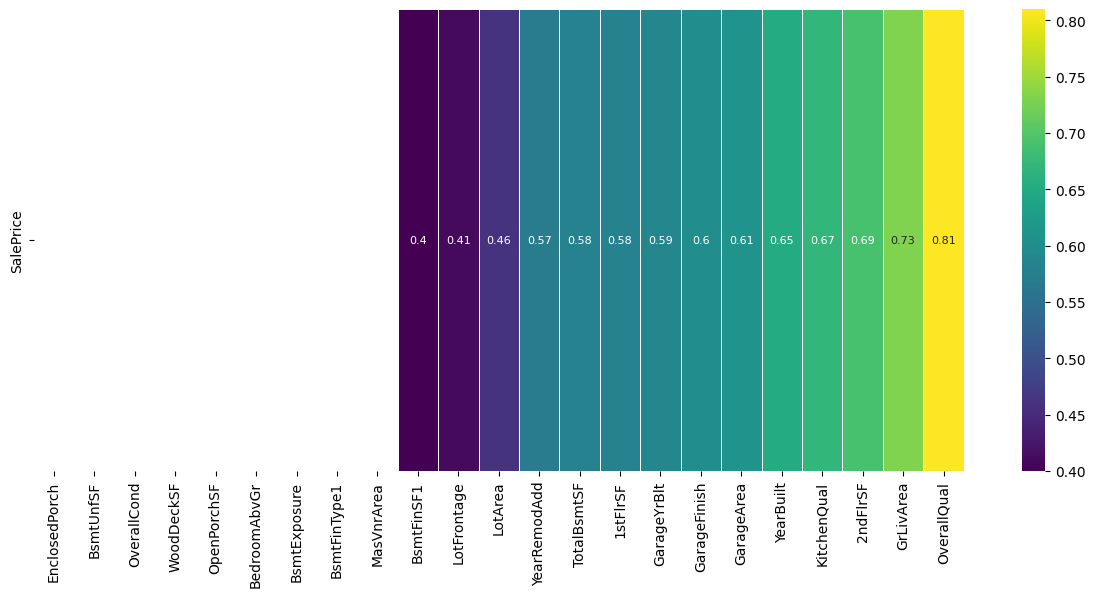

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(figsize=(15,6))
annot_size = 8

# Retain only correlation values above 0.4
mask = np.zeros_like(corr_df_rev, dtype=bool)
mask[corr_df_rev.abs() < 0.4] = True

sns.heatmap(data=corr_df_rev, annot=True, xticklabels=True, yticklabels=True,
            mask=mask, cmap='viridis', annot_kws={"size": annot_size}, ax=axes,
            linewidth=0.5)

plt.show()

The moderately strong correlation coefficients have values between 0.4 and 0.6. The strong correlation coefficients have values above 0.6. The house attribute most strongly correlated to the house price (with correlation coefficient 0.81) is the overall quality ('OverallQual') variable which is an ordinal variable.

In [17]:
# dtype_dic is a dictionary used to choose between a scatterplot and a strip plot
strongly_correlated = ['OverallQual', 'GrLivArea', '2ndFlrSF', 'KitchenQual', 'YearBuilt', 'GarageArea', 'GarageFinish']
moderately_correlated = ['GarageYrBlt', '1stFlrSF', 'TotalBsmtSF', 'YearRemodAdd', 'LotArea', 'LotFrontage', 'BsmtFinSF1']
dtype_dict = {'OverallQual': 'object', 'GrLivArea': 'numeric', '2ndFlrSF': 'numeric', 'KitchenQual': 'object', 'YearBuilt': 'numeric', 'GarageArea': 'numeric', 'GarageFinish': 'object', 'GarageYrBlt': 'numeric', '1stFlrSF': 'numeric', 'TotalBsmtSF': 'numeric', 'YearRemodAdd': 'numeric', 'LotArea': 'numeric', 'LotFrontage': 'numeric', 'BsmtFinSF1': 'numeric'}

## Scatterplots between house attributes and sale price

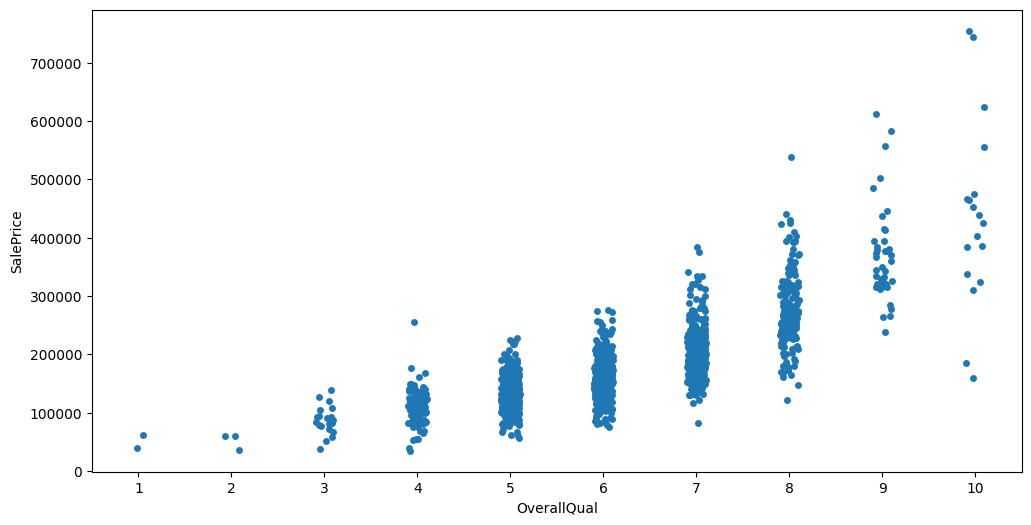

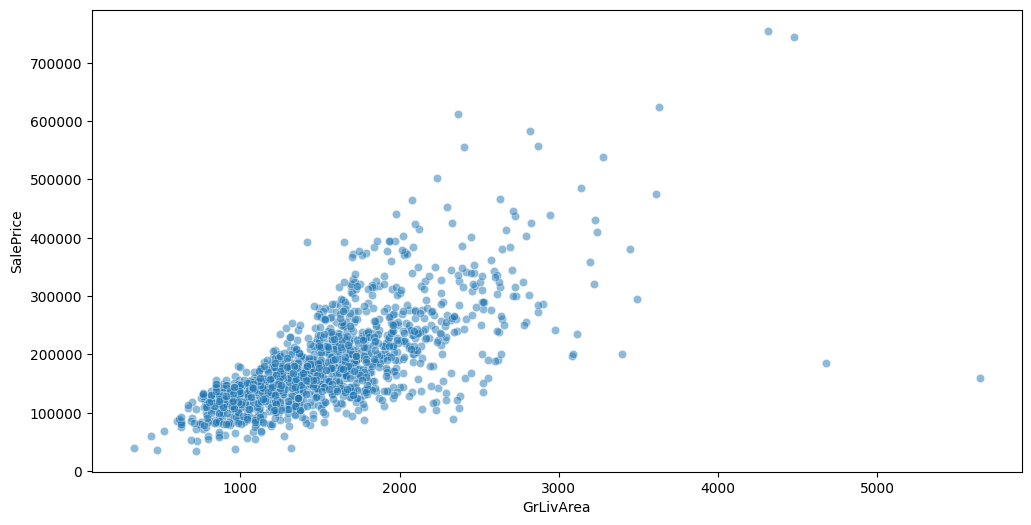

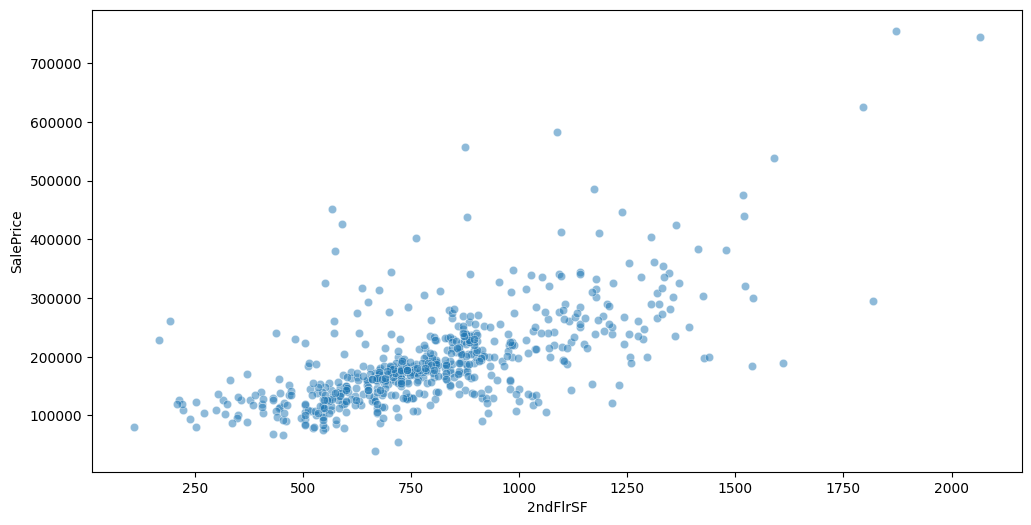

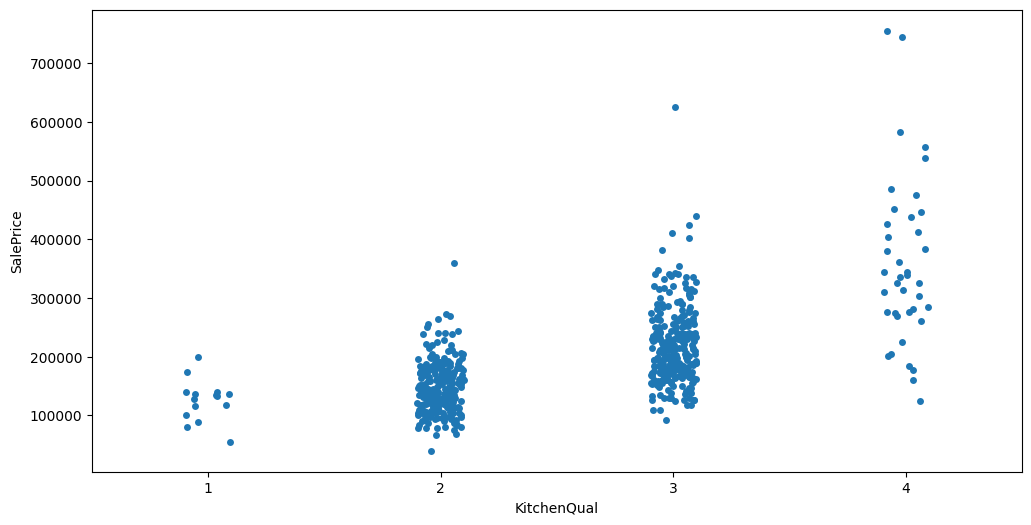

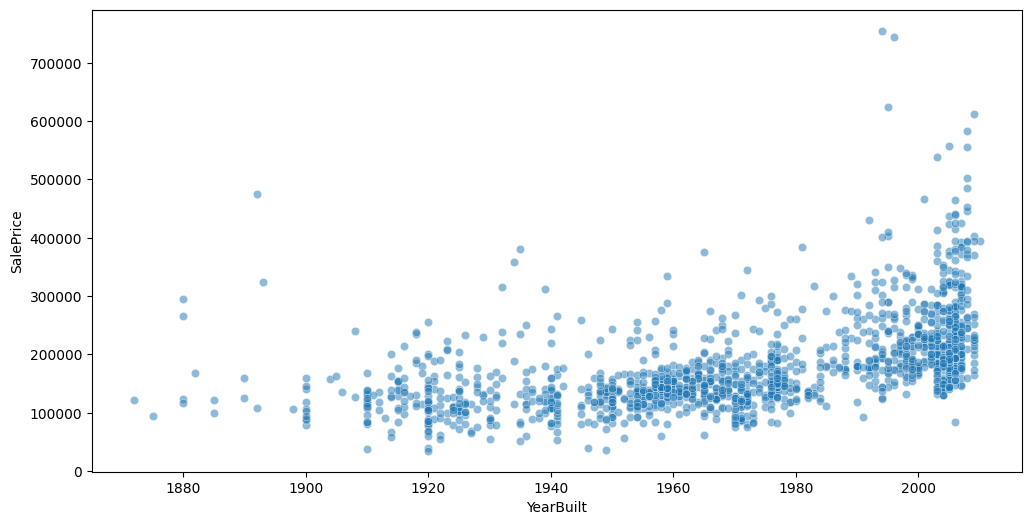

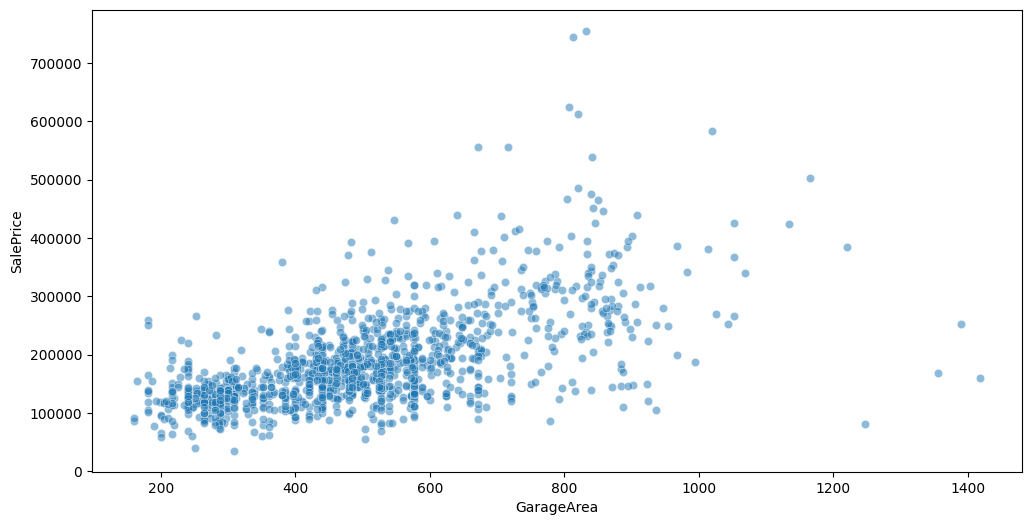

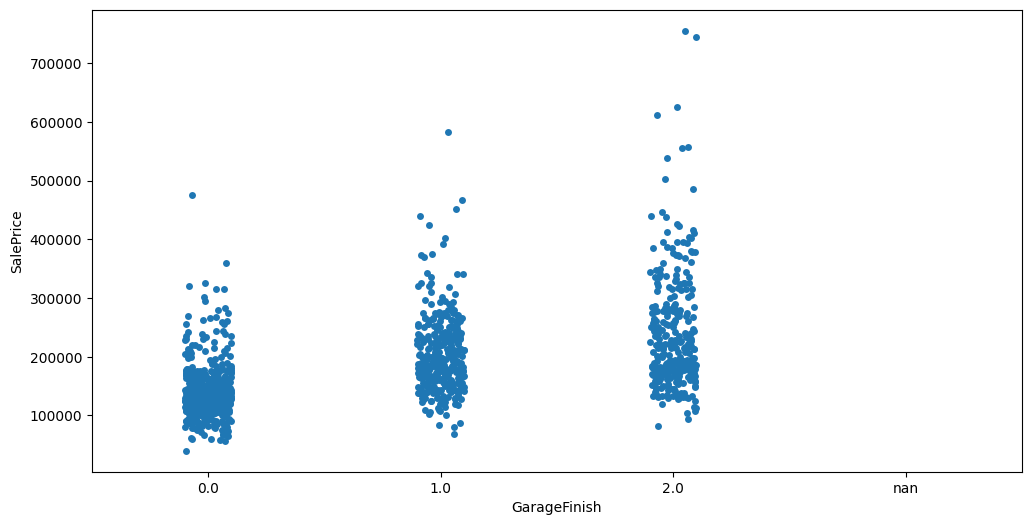

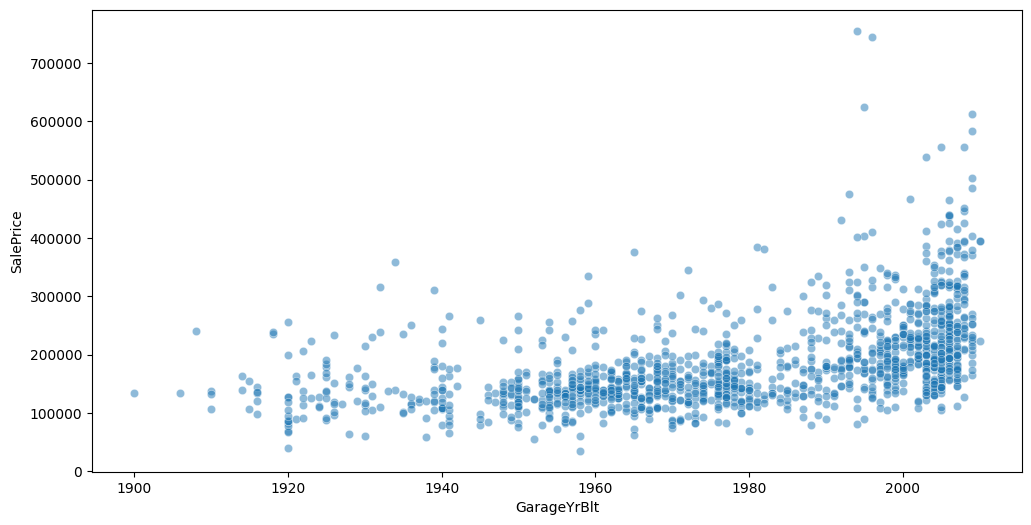

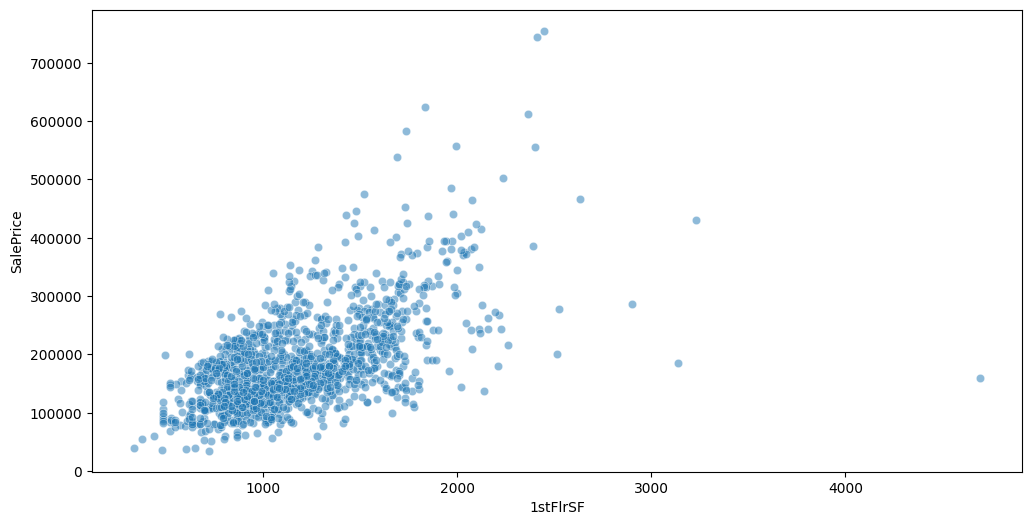

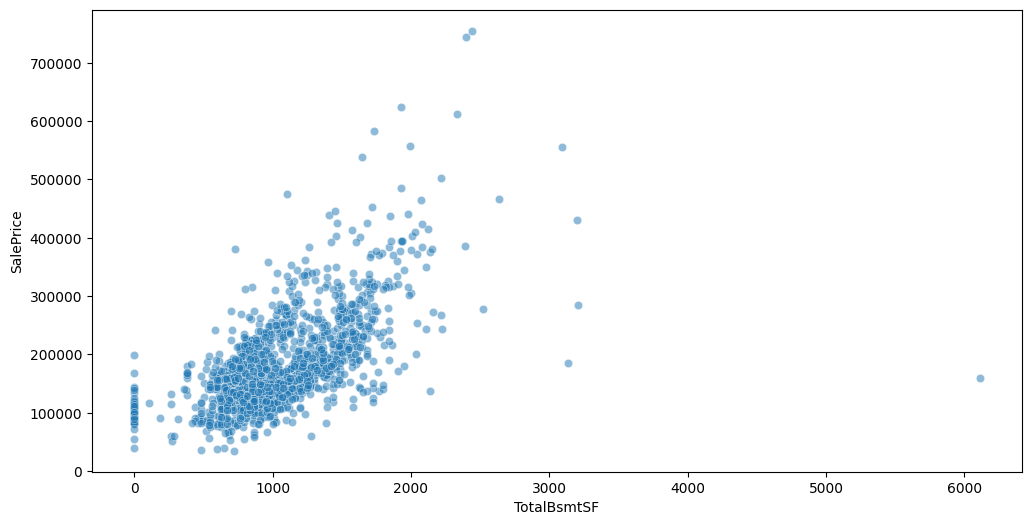

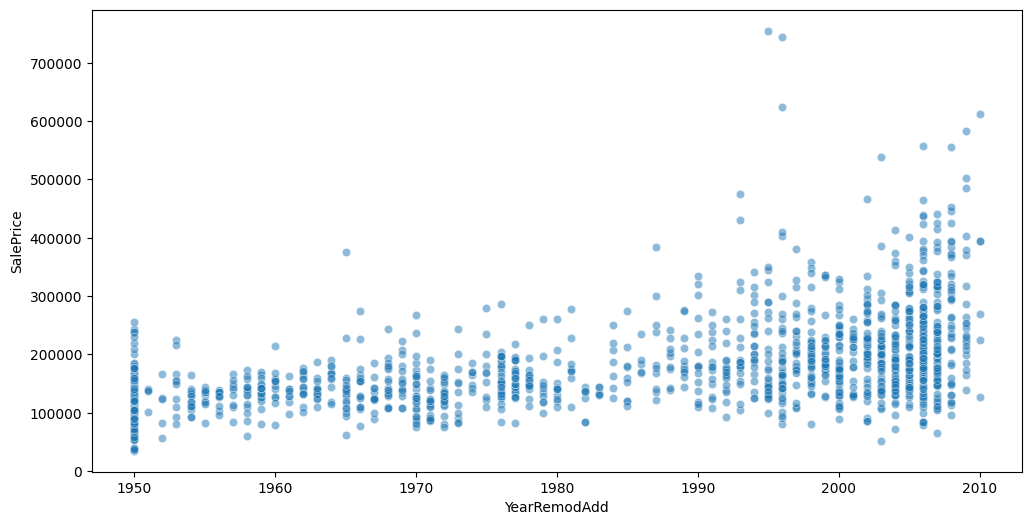

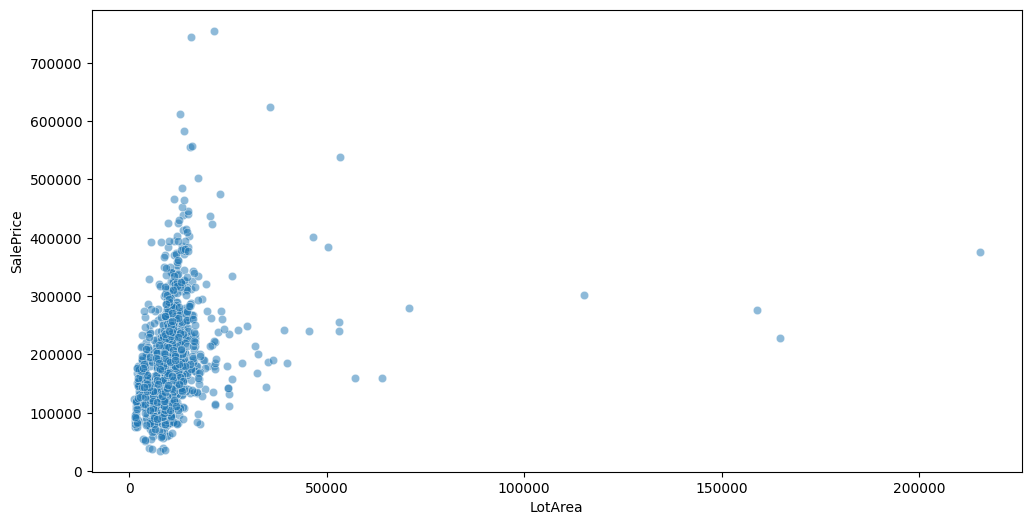

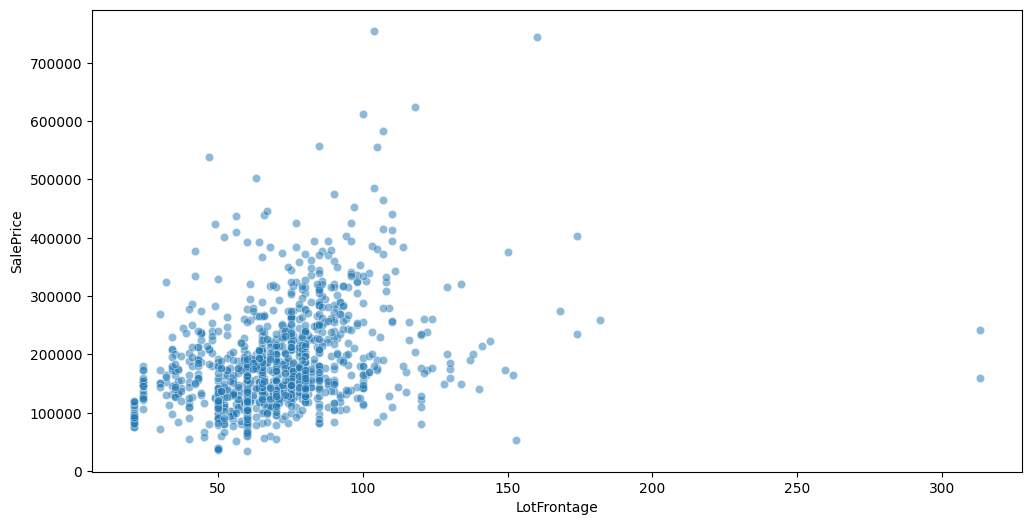

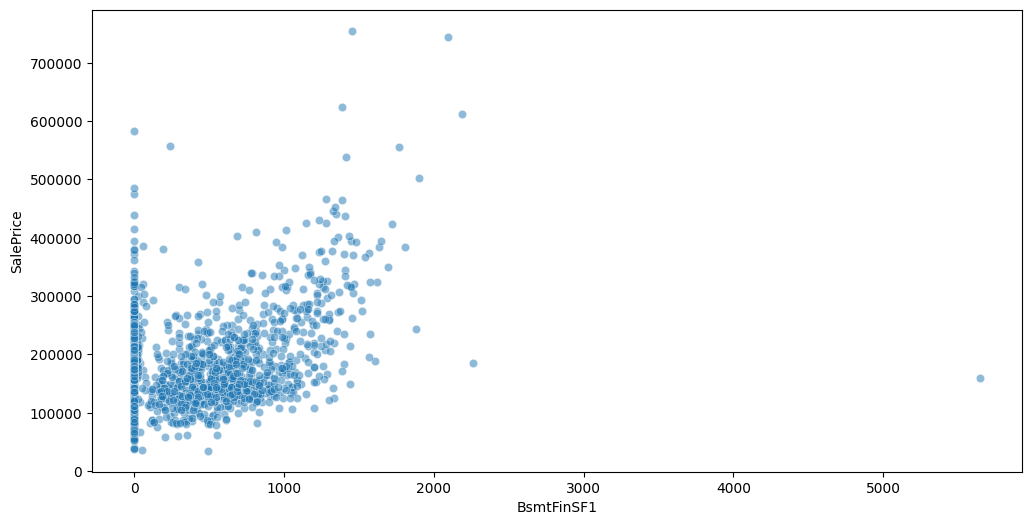

In [18]:
# Remove first zeros/None values and missing values
for col in strongly_correlated:
    if df[col].dtype == 'object':
        df1 = df[df[col]!='None']
        df2 = df1[df1[col].notnull()]
        df3[col] = df2[col].replace(dic[col])
    else:
        df1 = df[df[col]!=0]
        df3 = df1[df1[col].notnull()]
    if dtype_dict[col] == 'object':
        fig, axes = plt.subplots(figsize=(12,6))
        sns.stripplot(data=df3, x=col, y='SalePrice')
        plt.show()
    elif dtype_dict[col] == 'numeric':
        fig, axes = plt.subplots(figsize=(12,6))
        sns.scatterplot(data=df3, x=col, y='SalePrice', alpha=0.5)
        plt.show()

for col in moderately_correlated:
    if df[col].dtype == 'object':
        df1 = df[df[col]!='None']
        df2 = df1[df1[col].notnull()]
        df3[col] = df2[col].replace(dic[col])
    else:
        df1 = df[df[col]!=0]
        df3 = df1[df1[col].notnull()]
    if dtype_dict[col] == 'object':
        fig, axes = plt.subplots(figsize=(12,6))
        sns.stripplot(data=df, x=col, y='SalePrice')
        plt.show()
    elif dtype_dict[col] == 'numeric':
        fig, axes = plt.subplots(figsize=(12,6))
        sns.scatterplot(data=df, x=col, y='SalePrice', alpha=0.5)
        plt.show()

We see that the stronger the correlation the clearer the trend

# Explore sale price distribution

In [19]:
# Code from Code Institute Scikit lesson
sns.set_style("whitegrid")
def plot_histogram_and_boxplot(df):
  for col in df.columns:
    fig, axes = plt.subplots(nrows=2 ,ncols=1 ,figsize=(7,7), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df, x=col, ax=axes[0], whis=3)
    sns.histplot(data=df, x=col, kde=True, ax=axes[1])
    fig.suptitle(f"{col} Distribution - Boxplot and Histogram")
    plt.show()

    # An outlier is defined to be outside the box in the boxplot by three times the
    # interquantile distance
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    print(
        f"This is the range where a datapoint is not an outlier: from "
        f"{(df[col].quantile(q=0.25) - 3*IQR).round(2)} to "
        f"{(df[col].quantile(q=0.75) + 3*IQR).round(2)}")
    print("\n")

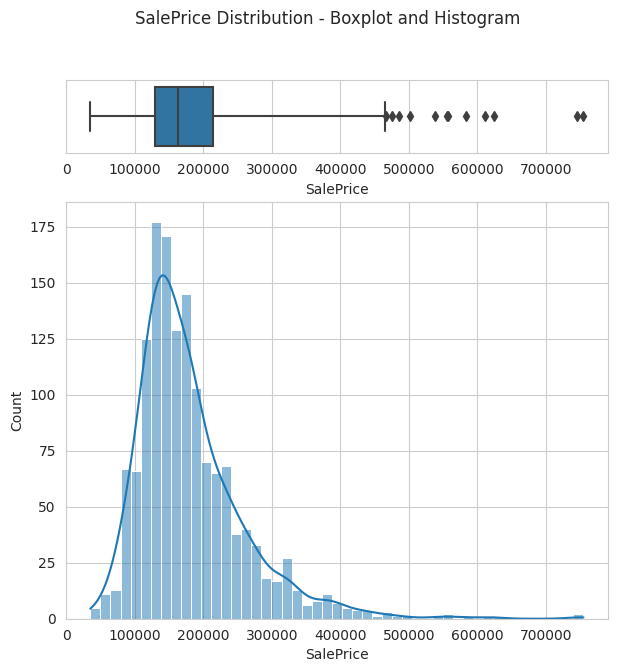

This is the range where a datapoint is not an outlier: from -122100.0 to 466075.0




In [20]:
df2=df.filter(['SalePrice'])
plot_histogram_and_boxplot(df2)

* We see that the distribution has a long right tail or in other words it is skewed to the right.

# Store correlation coefficients dataframe

In [21]:
import joblib
import os

version = 'v1'
file_path = f'outputs/house_prices_study/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [22]:
corr_df_rev.to_csv(f"{file_path}/corr_df_rev.csv", index=False)

## Store dictionary used for encoding object variables

In [23]:
joblib.dump(value=dic, filename=f"{file_path}/dic.pkl")

['outputs/house_prices_study/v1/dic.pkl']

---